In [169]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import pyDOE
from scipy.stats import pearsonr,spearmanr
from scipy.interpolate import interp1d

rez=100

In [170]:
#whole AB model
def Ab_model(t,A0,phi,r,s,hill,IC50):
    Ab_t = A0*(np.exp(-r*t)+phi*np.exp(-s*t))
    if A0>0:
        E_t = 1/(1+(Ab_t/IC50)**-hill)
    else:
        E_t=0
    return Ab_t,E_t

# # same death rate for U & P
# (12 free parameters + 5 initial conditions)
# - now productive and unproductive have same natural death rates
def model_cl(X,t,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g,A0,phi,r,s,hill,IC50,psi):  
    dY = np.zeros(7);
    Ab_t,E_t = Ab_model(t,A0,phi,r,s,hill,IC50)    

    S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
    
    dY[0] = aS - dS*S - Bt*S*V                         #susceptible cells
    dY[1] = (1-tau)*Bt*S*V - dI*AU - k*E*AU + xi*LU    #active unproductively infected
    dY[2] = tau*Bt*S*V - dI*AP - k*E*AP + xi*LP        #active productively infected
    dY[3] = (1-tau)*lam*Bt*S*V + thL*LU                #latent unproductively infected
    dY[4] = tau*lam*Bt*S*V + thL*LP                    #latent productively infected
    dY[5] = w*E*(AP+AU)/(E+E50) + aE - dE*E;           #adaptive immune system
    dY[6] = p*AP - g*V - Bt*S*V - psi*Ab_t*V           #virus (with extra Ab clearance)
    return dY

def model(X,t,aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g,A0,phi,r,s,hill,IC50,psi):  
    dY = np.zeros(7);
    Ab_t,E_t = Ab_model(t,A0,phi,r,s,hill,IC50)    

    S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
    
    Bt=Bt0*(1-E_t)
    
    dY[0] = aS - dS*S - Bt*S*V                         #susceptible cells
    dY[1] = (1-tau)*Bt*S*V - dI*AU - k*E*AU + xi*LU    #active unproductively infected
    dY[2] = tau*Bt*S*V - dI*AP - k*E*AP + xi*LP        #active productively infected
    dY[3] = (1-tau)*lam*Bt*S*V + thL*LU                #latent unproductively infected
    dY[4] = tau*lam*Bt*S*V + thL*LP                    #latent productively infected
    dY[5] = w*E*(AP+AU)/(E+E50) + aE - dE*E;           #adaptive immune system
    dY[6] = p*AP - g*V - Bt*S*V                        #virus
    return dY

def run_model(tt,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g,A0,phi,r,s,hill,IC50,psi,X0):
    sol=spi.odeint(model, X0, tt, 
               (aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g,A0,phi,r,s,hill,IC50,psi),
               mxstep=1000)
    return sol


2.8905527289546726


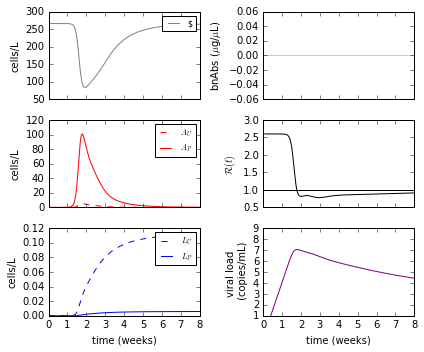

In [171]:
# parameters for viral dynamics model
vol = 1      # volume of blood [uL]
aS  = 125*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.47;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1.0       # active death rate [1/day]
p   = 2e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.05      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 0.3/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 260*vol;   #50 pct max E cell concentration [cells/uL]*[uL]
tau = 0.05   #productively infected probability
p   = 5e4    #leak+burst viral production rate [virions/cell]
g   = 23      #viral clearance [1/day]

#equilibriu solutions
#l=1-(1+xi/thL)*tau #latency factor
#Xeq=np.array([g*dA/Bt0/p/l,tau/thL*(g*dS*dA/Bt0/p/l-aS),aS*l/dA-g*dS/Bt0/p,aS*p*l/g/dA-dS/Bt0])

R0=aS*Bt0*tau*(1-lam)*p/g/dS/dA; print(R0) # basic reproductive number

#PK parameters
A0,phi,r,s = 0, 0, 0.348, 0.0538 #low 30 or high 10 dose range

#PD parameters
IC50=20 # IC50 [ug/uL]
hill=1  # hill coefficient []
psi=3

x0=np.array([aS/dS,0,0,0,0,aE/dE,1e-3]) #initial model conditions

tt=np.linspace(0,7*8,1e3)

sol=run_model(tt,aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g,A0,phi,r,s,hill,IC50,psi,x0)

#Ab model
Ab_t,E_t  = Ab_model(tt,A0,phi,r,s,hill,IC50)

#calculate R0(t)
dIdt=np.diff(sol[:,2])
I=sol[1:,2]
dt=tt[1]
Rt=1+dIdt/(I*dt*dA)

fig,axarr=plt.subplots(3,2,figsize=(6,5),dpi=rez,sharex=True)
titz=[r'$S$','$A_U$','$A_P$','$L_U$','$L_P$','$E$','$V$']

axarr[0][0].plot(tt/7,sol[:,0],color='gray')
axarr[0][0].set_ylabel('cells/L')
axarr[0][0].legend(titz[0],fontsize=8,loc=1)

axarr[1][0].plot(tt/7,sol[:,2],color='red',ls='--')
axarr[1][0].plot(tt/7,sol[:,1],color='red')
axarr[1][0].set_ylabel('cells/L')
axarr[1][0].legend(titz[1:3],fontsize=8,loc=1)

axarr[2][0].plot(tt/7,sol[:,3],color='blue',ls='--')
axarr[2][0].plot(tt/7,sol[:,4],color='blue')
axarr[2][0].legend(titz[3:],fontsize=8,loc=1)
axarr[2][0].set_ylabel('cells/L')

axarr[0][0].set_xticks(range(9))
axarr[2][0].set_xlabel('time (weeks)')

#plot viral stuff
axarr[0][1].plot(tt/7,Ab_t,color='gold')
axarr[0][1].set_ylabel('bnAbs ($\mu$g/$\mu$L)')
    
axarr[1][1].plot(tt[10:]/7,Rt[9:],color='black')
axarr[1][1].axhline(1,color='k')
axarr[1][1].set_xticks(range(9))
axarr[1][1].set_ylabel(r'$\mathcal{R}(t)$')
#axarr[1].set_yticks(np.linspace(0,9,4))

axarr[2][1].plot(tt/7,np.log10(sol[:,6]/vol*1e3),color='purple') #virus/mL
axarr[2][1].set_ylim([1,9])
axarr[2][1].set_yticks(np.linspace(1,9,9))
axarr[2][1].set_ylabel('viral load \n (copies/mL)')
axarr[2][1].set_xlabel('time (weeks)')

plt.tight_layout()
plt.savefig('figures/det_model.pdf')

baseline_VL=np.log10(sol[:,6])

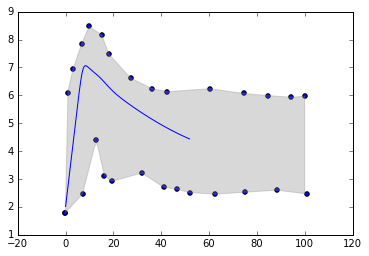

In [172]:
#now fit Robb VL
robb=pd.read_csv('data/robb_ranges.csv',names=['logVL','days'])
robbHI=robb[:15]
robbLO=robb[15:]

plt.scatter(robbLO.days,robbLO.logVL)
plt.scatter(robbHI.days,robbHI.logVL)

interpLO=interp1d(robbLO.days,robbLO.logVL)
interpHI=interp1d(robbHI.days,robbHI.logVL)

xnew=np.linspace(0,100,num=100)

#show our baseline params work
plt.fill_between(xnew, interpLO(xnew), interpHI(xnew),color='gray',alpha=0.3)

vll=np.log10(sol[:,6]/vol*1e3)

fpoz=np.where(vll>2)[0][0]

plt.plot(tt[:-fpoz],vll[fpoz:])

/Users/danielreeves/anaconda/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


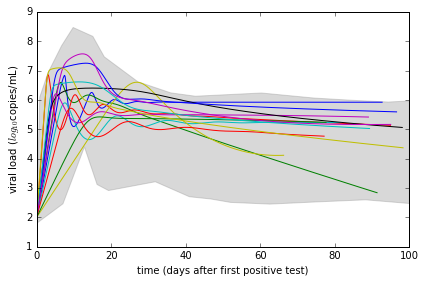

In [173]:
#now see which parameter ranges fit in here

sampz=10**3

x0=np.array([aS/dS,0,0,0,0,aE/dE,1e-3]) #initial model conditions

tt=np.linspace(0,100,1e4)

loV,hiV = interpLO(tt),interpHI(tt) #the bounds

guessP=np.array([aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g])

goodP_list=[]

bdz=1.#extra bounds for fitting shaded area

for i in range(sampz):
    aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr=np.random.lognormal(0,2,[15])*guessP

    #x0r=np.random.lognormal(0,1,[7])*x0
    x0r=x0
    
    sol=run_model(tt,aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr,0,0,0,0,0,0,0,x0r)
    
    vll=np.log10(sol[:,6]/vol*1e3)

    if (vll>-100).all() & (vll>2).any():        
        
        fpoz=np.where(vll>2)[0][0]

        if ~ ((vll[fpoz:]>hiV[:-fpoz]*bdz).any() | (vll[fpoz:]<loV[:-fpoz]/bdz).any()):
            goodP_list.append([aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr])#,x0r])
       
            plt.plot(tt[:-fpoz],vll[fpoz:])#,color='k',alpha=0.5)
        
plt.fill_between(tt, loV, hiV, color='gray',alpha=0.3)
plt.xlabel('time (days after first positive test)')
plt.ylabel('viral load ($log_{10}$copies/mL)')
plt.tight_layout()
plt.savefig('figures/robb_examples.pdf')

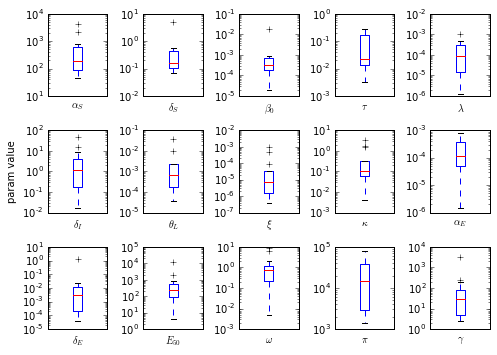

In [174]:
pnames=[r'$\alpha_S$',r'$\delta_S$',r'$\beta_0$',r'$\tau$',r'$\lambda$',
        r'$\delta_I$',r'$\theta_L$',r'$\xi$',r'$\kappa$',r'$\alpha_E$',
        r'$\delta_E$',r'$E_{50}$',r'$\omega$',r'$\pi$',r'$\gamma$']
        
plt.figure(figsize=(7,5),dpi=rez)
for j in range(15):
    plt.subplot(3,5,j+1)
    plt.boxplot(np.array(goodP_list)[:,j])
    plt.yscale('log')
    plt.xlabel(pnames[j])
    plt.xticks([])
    if j==5:
        plt.ylabel('param value')
plt.tight_layout()
plt.savefig('figures/robb_fitparams.pdf')

In [175]:
#updating the rates of events
num_rates=21; num_states=7; rl=np.zeros(num_rates); T=np.zeros([num_rates,num_states])

def update_rates(X,ti,A0,phi,r,s,hill,IC50,psi):
        
    Ab_t,E_t = Ab_model(ti%56,A0,phi,r,s,hill,IC50)    #refreshes every 8 weeks

    Bt=Bt0*(1-E_t) #ab dependent infectivity
    
    S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
    
    #kp=0.1; pr=np.random.gamma(kp,p)
    pr=np.random.poisson(p)
    
    rl[0] = aS;                     T[0][:]=[ 1,0,0,0,0,0,0];  #constant production 
    rl[1] = dS*S;                   T[1][:]=[-1,0,0,0,0,0,0]  #density dependent susceptible death
    rl[2] = (1-tau)*(1-lam)*Bt*S*V; T[2][:]=[-1,1,0,0,0,0,-1] #unproductive active infection
    rl[3] = tau*(1-lam)*Bt*S*V;     T[3][:]=[-1,0,1,0,0,0,-1] #productive active infection
    rl[4] = (1-tau)*lam*Bt*S*V;     T[4][:]=[-1,0,0,1,0,0,-1] #unproductive latent infection
    rl[5] = tau*lam*Bt*S*V;         T[5][:]=[-1,0,0,0,1,0,-1] #productive latent infection
    rl[6] = dA*AU;                  T[6][:]=[0,-1,0,0,0,0,0]  #unproductive active death
    rl[7] = dA*AP;                  T[7][:]=[0,0,-1,0,0,0,pr]  #productive active death and virus burst
    rl[8] = dL*LU;                  T[8][:]=[0,0,0,-1,0,0,0]  #unproductive latent death
    rl[9] = dL*LP;                  T[9][:]=[0,0,0,0,-1,0,0]  #productive latent death
    rl[10] = aL*LU;                 T[10][:]=[0,0,0,1,0,0,0]  #unproductive latent proliferation
    rl[11] = aL*LP;                 T[11][:]=[0,0,0,0,1,0,0]  #productive latent proliferation
    rl[12] = xi*LU;                 T[12][:]=[0,1,0,-1,0,0,0]  #unproductive latent activation
    rl[13] = xi*LP;                 T[13][:]=[0,0,1,0,-1,0,0]  #productive latent activation
    rl[14] = k*E*AU;                T[14][:]=[0,-1,0,0,0,0,0]  #unproductive active immune removal
    rl[15] = k*E*AP;                T[15][:]=[0,0,-1,0,0,0,0]  #productive active immune removal
    rl[16] = w*E*(AP+AU)/(E+E50);   T[16][:]=[0,0,0,0,0,1,0]  #immune cell recruitment
    rl[17] = aE;                    T[17][:]=[0,0,0,0,0,1,0]  #immune cell birth
    rl[18] = dE*E;                  T[18][:]=[0,0,0,0,0,-1,0]  #immune cell clearance
    rl[19] = g*V;                   T[19][:]=[0,0,0,0,0,0,-1]  #innate viral clearance
    #rl[20] = psi*Ab_t*V;            T[20][:]=[0,0,0,0,0,0,-1]  #bnAb viral clearance
    
    return rl,T

#function that solves stochastically using tau-leap method
def bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi):

    dt=t[1]; x=np.array([aS/dS,0,0,0,0,aE/dE,0]); y=[] #initialize
    fp_flag='no'
    for ti in t:
        
        y.append(x) #the list of states

        rate_list,T = update_rates(x,ti,A0,phi,r,s,hill,IC50,psi) #make new rate vector
        
        events = np.random.poisson(rate_list*dt) #calculate events
        
        events_list.append(events)
        
        dx = np.sum(np.matrix.transpose(T)*events,1) #calculate change in state
        
        x=x+dx #update state variable
        
        if ti>fp_time and fp_flag=='no':
            x[2] = x[2] + 1
            fp_flag=='yes'
 
        x[x<1]=0 #make sure no negative numbers or fractions
                
    return np.array(y)

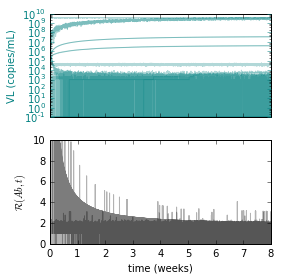

In [176]:
#do simulations

A0,phi,r,s = 1,0,0.348,0.0538 #low 30 or high 10 dose range
#A0,phi,r,s = 225,35,0.348,0.0538 #low 30 or high 10 dose range
IC50=2
hill=1
psi=0.01

num_sims=3; 
tt=np.linspace(0,8*7,1e5)

fp_time=0

Ab_t,E_t = Ab_model(tt%56,A0,phi,r,s,hill,IC50)    #refreshes every 8 weeks

col1='teal'
col2='black'

fig, ax = plt.subplots(2,1,figsize=(4,4),dpi=rez,sharex=True)
#figE, axE = plt.subplots(3,7,figsize=(6,12),dpi=rez,sharex=True)
ax1=ax[0]
ax2=ax[1]
rr=10
for i in range(num_sims):
    events_list=[]
    
    aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g=goodP_list[np.random.randint(0,len(goodP_list))] #choose a random "good parameter set"

    tlp_sol = bnabs_tauleap(tt,0,A0,phi,r,s,hill,IC50,psi)
    #axE[int(i/7)][i%7].plot(tt,np.array(E_list)[:,i])
    dIdt=np.diff(tlp_sol[:,2])
    I=tlp_sol[1:,2]
    dt=tt[1]
    Rt=1+dIdt/(I*dt*dA)
    ax1.semilogy(tt/7,tlp_sol/vol*1e3+0.1,alpha=0.3,color=col1)
    #ax1.semilogy(tt[0::rr]/7,tlp_sol[0::rr,6]/vol*1e3+0.1,alpha=0.3,color=col1) #downsample
    ax2.plot(tt[1::rr]/7,Rt[0::rr],color=col2,alpha=0.3)

ax1.set_ylabel('VL (copies/mL)',color=col1)
ax2.set_xlabel('time (weeks)')
ax1.tick_params('y', colors=col1)
#ax1.set_ylim([30,1e8])
#ax1.set_yticks(np.logspace(1,8,8))
ax2.set_ylabel('$\mathcal{R}(Ab,t)$',color=col2)
ax2.tick_params('y', colors=col2)
ax2.set_ylim([0,10])
ax2.set_xticks(range(9))

fig.tight_layout()

fig.savefig('figures/sto_virus.pdf')  # No warning now


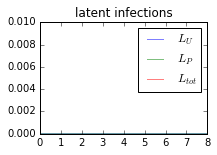

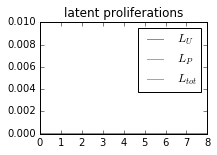

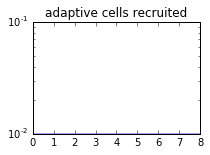

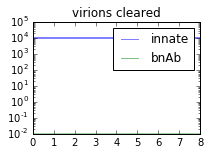

In [184]:
#latent events
EE=np.array(events_list)
plt.figure(figsize=(3,2),dpi=rez)
plt.plot(tt/7,EE[:,4],alpha=0.5)
plt.plot(tt/7,EE[:,5],alpha=0.5)
plt.plot(tt/7,EE[:,4]+EE[:,5]+0.01,alpha=0.5)
plt.legend(['$L_U$','$L_P$','$L_{tot}$'])
plt.title('latent infections')

plt.figure(figsize=(3,2),dpi=rez)
plt.plot(tt/7,EE[:,10],alpha=0.5)
plt.plot(tt/7,EE[:,11],alpha=0.5)
plt.plot(tt/7,EE[:,10]+EE[:,11]+0.01,alpha=0.5)
plt.legend(['$L_U$','$L_P$','$L_{tot}$'])
plt.title('latent proliferations')

plt.figure(figsize=(3,2),dpi=rez)
plt.semilogy(tt/7,EE[:,16]+0.01,alpha=0.5)
plt.title('adaptive cells recruited')

plt.figure(figsize=(3,2),dpi=rez)
plt.semilogy(tt/7,EE[:,19]+0.01,alpha=0.5)
plt.semilogy(tt/7,EE[:,20]+0.01,alpha=0.5)
plt.legend(['innate','bnAb'])
plt.title('virions cleared')


In [ ]:

################################################################################
#local sensitivity analysis function

#variables to check sensitivity
variables = ['first positive time ' + r'$t_{+}$',
             'initial bnAb conc ' + r'$A_0$', 
             '2nd phase bnAb ratio ' + r'$\phi$',
             'decay rate 1 ' + r'$r$',
             'decay rate 2 ' + r'$s$',
             'Hill coefficient ' + r'$h$',
             '50% effectiveness ' + r'$IC_{50}$',
            'stochastic variation']#,'bnAb efficacy ' + r'$\psi$']

#from data_analysis fitting:
#[86  2.5 0.15 0.007] +/- [ 32.7 32.6 0.12 0.29 ]
#[240 2.9 0.086 -0.011] +/- [ 112 116 0.081 0.71]

#ranges of variables for LHS, mostly made up to consider all options
rangez= np.array([
            [0,56],   #t+
            [0,600],  #A0
            [0,20],  #phi
            [0,0.3],  #r
            [0,0.7],  #s
            [1,5],    #h
            [0.2,20], #IC50
            [0,10]])  #psi 
                            
t=np.linspace(0,56,1e3) #8 week time series in days

fig,axarr = plt.subplots(2,4,sharex=True,sharey=True,figsize=(9,4),dpi=rez)
#looping over the number of variables to check sensitivity
for i in range(len(variables)):

    #set values at initials, mean??
    lo=np.mean(rangez,1); hi=np.mean(rangez,1);      

    lo[0]=7; hi[0]=7; #make sure first pos is at 1 week
    
    #change the i-th parameter
    lo[i]=rangez[i][0]; hi[i]=rangez[i][1]
    
    #evaluate model
    fp_time,A0,phi,r,s,hill,IC50,psi=lo
    lo_sol = bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi)
    
    fp_time,A0,phi,r,s,hill,IC50,psi=hi
    hi_sol = bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi)

    ax=axarr[i%2][int(i/2.)]
    ax.fill_between(t/7,lo_sol[:,6]/vol*1e3,hi_sol[:,6]/vol*1e3,alpha=0.6)
    #ax.semilogy(t/365,med[5],t,HI_sol[5],alpha=0.1,color='chocolate')
    #ax.fill_between(t/365,LO_sol[5],HI_sol[5],alpha=0.5,color='tomato') #observed
    #ax.fill_between(t/365,LO_sol[6],HI_sol[6],alpha=0.5,color='limegreen') #de novo

    #ax.set_ylim([0.1,100])
    ax.set_title(variables[i],fontsize=10)# + str(rangez[i][0]) + r'$\to$' +str(rangez[i][1]),fontsize=10)
    ax.set_xticks(np.linspace(0,8,9))

axarr[0][0].set_ylabel('VL (copies/mL)',fontsize=10)
axarr[1][0].set_ylabel('VL (copies/mL)',fontsize=10)
axarr[0][0].set_ylim([1,2e8])
axarr[0][0].set_yscale('log')

for i in range(4):
    axarr[1][i].set_xlabel('time (weeks)')

axarr[0][0].set_yticks(np.logspace(1,8,8))

plt.tight_layout()
plt.savefig('figures/sensitivity_local.pdf')




In [ ]:
################################################################################
#global sensitivity analysis function

sampz=500

lhs_samples = pyDOE.lhs( int(len(variables)), samples=sampz, criterion='center')

t=np.linspace(0,56,1e3) #8 week time series in days

var_vals=np.zeros(len(variables))
var_vals_list=np.zeros([len(variables),sampz])

peak_list=np.zeros(sampz)
tpeak_list=np.zeros(sampz)
sp_list=np.zeros(sampz)
CD8_list=np.zeros(sampz)

if sampz<101:
    fig, ax = plt.subplots(1,2,figsize=(4,3),dpi=rez,sharex=True)

#looping over the number of LHS samples
for i in range(sampz):

    #I3_0    = 10**(np.log10(rangez[0][0]) + lhs_samples[i][0]*(np.log10(rangez[0][1])-np.log10(rangez[0][0])))

    #make the variable values using the LHS sampling
    for j in range(len(variables)):
        var_vals[j]=rangez[j][0] + lhs_samples[i][j]*(rangez[j][1]-rangez[j][0])

    var_vals_list[:,i]=var_vals
    
    fp_time,c1,c2,r1,r2,hill,IC50,psi=var_vals
    sol = bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi) #solve the model for this LHS list

    fp_index=np.argwhere(fp_time<t)[0][0]
    peak=np.max(sol[fp_index:,6]/vol*1e3)
    tpeak=t[np.argwhere(sol[:,6]/vol*1e3==peak)[0][0]]    

    peak_list[i]=peak
    tpeak_list[i]=tpeak
    CD8_list[i]=sol[-1,5]
    
    if (fp_index+250)<len(t):
        sp=np.mean(sol[fp_index+250:,6]/vol*1e3) #2 weeks later
    else:
        sp=0
        
    sp_list[i]=sp

    if sampz<101:
        #make plots showing variation              
        ax[0].semilogy(t/7,sol[:,6]/vol*1e3,alpha=0.3)
        ax[0].set_ylabel('VL (copies/mL)')
        ax[0].set_xlabel('time (weeks)')

        Ab_t,E_t = Ab_model(t%56,c1,c2,r1,r2,hill,IC50)    #refreshes every 8 weeks
        ax[1].plot(t/7, R0*(1-E_t),alpha=0.3)
        ax[1].set_ylabel('$\mathcal{R}(Ab,t)$')
        ax[0].set_xlabel('time (weeks)')
        ax[0].set_xticks(np.linspace(0,8,9))

if sampz<101:
    plt.tight_layout()
    plt.savefig('figures/examples.pdf')

In [ ]:
vars_short = ['first pos ' + r'$t_{+}$',
             'initial bnAb conc ' + r'$A_0$', 
             'phase bnAb ratio ' + r'$\phi$',
             'decay 1 ' + r'$r$',
             'decay 2 ' + r'$s$',
             'Hill coef ' + r'$h$',
             '50% effect ' + r'$IC_{50}$',
             'bnAbs ' + r'$\psi$']

corr_peak=np.zeros([len(variables),2])
corr_tpeak=np.zeros([len(variables),2])
corr_sp=np.zeros([len(variables),2])
corr_CD8=np.zeros([len(variables),2])

fig,axarr = plt.subplots(4,7,figsize=(14,8),dpi=rez)
for i in range(len(variables)-1):

    #compute correlations (ranked via spearman)
    corr_peak[i]=spearmanr(var_vals_list[i,:],peak_list)
    corr_tpeak[i]=spearmanr(var_vals_list[i,:],tpeak_list)
    corr_sp[i]=spearmanr(var_vals_list[i,:],sp_list)
    corr_CD8[i]=spearmanr(var_vals_list[i,:],CD8_list)

    #because of artificial stopping time for sp calculation
    if i==0:
        corr_sp[i]=spearmanr(var_vals_list[i,:-250],sp_list[:-250])
        
    ax=axarr[0][i]
    ax.scatter(var_vals_list[i,:],peak_list,s=10,alpha=0.5,c='teal')
    #ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_ylim([1,2e7])
    ax.set_xlim(rangez[i])
    ax.set_yticks(np.logspace(0,7,8))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

    ax=axarr[1][i]
    ax.scatter(var_vals_list[i,:],tpeak_list/7,s=10,alpha=0.5,c='tan')
    #ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xlim(rangez[i])
    #ax.set_xscale('log')
    ax.set_yticks(np.linspace(0,8,9))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

    ax=axarr[2][i]
    ax.scatter(var_vals_list[i,:],sp_list,s=10,alpha=0.5,c='gray')
    #ax.set_xticks(ax.get_xticks()[::2])
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e3,2e7])
    #ax.set_xlabel(vars_short[i],fontsize=10)
    ax.set_xlim(rangez[i])
    ax.set_yticks(np.logspace(3,7,5))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

    ax=axarr[3][i]
    ax.scatter(var_vals_list[i,:],CD8_list,s=10,alpha=0.5,c='olive')
    #ax.set_xticks(ax.get_xticks()[::2])
    #ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_ylim([1e3,2e7])
    ax.set_xlabel(vars_short[i],fontsize=10)
    ax.set_xlim(rangez[i])
    #ax.set_yticks(np.logspace(3,7,5))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

axarr[0][0].set_ylabel('peak VL \n (copies/mL)',fontsize=10)
axarr[1][0].set_ylabel('time to peak \n (weeks)',fontsize=10)
axarr[2][0].set_ylabel('setpoint VL \n (copies/mL)',fontsize=10)
axarr[3][0].set_ylabel('adaptive cells \n (cells/$\mu$L)',fontsize=10)

plt.tight_layout()
plt.savefig('figures/sensitivity_global_scatters.pdf')


In [ ]:

vars_short = ['first pos ' + r'$t_{+}$',
             'initial bnAb conc ' + r'$A_0$', 
             'phase bnAb ratio ' + r'$\phi$',
             'decay 1 ' + r'$r$',
             'decay 2 ' + r'$s$',
             'Hill coef ' + r'$h$',
             '50% effect ' + r'$IC_{50}$',
             '']

#correlation coefficient bar plots
plt.figure(figsize=(4,5),dpi=rez)
bspace=np.arange(0,len(variables)*2,2)

#sort the variable names for y axis labels
#indz=cum_corrs[:,0].argsort()
#sorted_vars=[]
#for kk in range(len(variables)):
#    sorted_vars.append(variables[indz[kk]])

corrs=[corr_peak,corr_tpeak,corr_sp,corr_CD8]
cz=['teal','orchid','coral','olive']

llist=[]
for i in range(4):
    l=plt.barh(bspace+i*0.3,corrs[i][:,0],0.4,color=cz[i])
    llist.append(l)
    plt.legend(llist,['peak','tpeak','setpoint','adaptive'],fontsize=8,loc='upper center', bbox_to_anchor=(0.6, 1.), ncol=2)
    pval_list=(corrs[i][:,1]<0.05) & (corrs[i][:,1]>0)
    for j in range(len(pval_list)):
        if pval_list[j]==True:
            plt.scatter(-1.2,bspace[j]+i*0.3,color=cz[i],marker='o',s=10)
    pval_list=(corrs[i][:,1]<0.01) & (corrs[i][:,1]>0)
    for j in range(len(pval_list)):
        if pval_list[j]==True:
            plt.scatter(-1.4,bspace[j]+i*0.3,color=cz[i],marker='*',s=10)

#plt.xscale('log')

plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlim([-1.5,1])
plt.xticks(np.linspace(-1,1,5))

plt.xlabel('spearman correlation '+ r'$\rho$',fontsize=10)
#plt.grid('on')
plt.yticks(bspace,vars_short,fontsize=8)
plt.axvline(-1.1,color='k',lw=0.8)
plt.tight_layout()


plt.savefig('figures/sensitivity_correlation_bars.pdf')
    


In [ ]:
tfirst=var_vals_list[0,:]
A0=var_vals_list[1,:]
phi=var_vals_list[2,:]
r=var_vals_list[3,:]
s=var_vals_list[4,:]
h=var_vals_list[5,:]
A50=var_vals_list[6,:]

At=A0*(np.exp(-tfirst*r)+phi*np.exp(-tfirst*s))

ee=1/(1+(A50/At)**(h))

RA=R0*(1-ee)

#compare At and various metrics
plt.figure(figsize=(7,3),dpi=rez)

plt.subplot(131)
plt.scatter(At,peak_list)
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('peak VL (copies/mL)')
#plt.xlabel('Ab conc at $t_+$ (mg/mL)')

plt.subplot(132)
plt.scatter(At,tpeak_list/7)
#plt.xscale('log')
plt.ylabel('time at peak viral load (weeks)')
plt.xlabel('Ab conc at $t_+$ (mg/mL)')

plt.subplot(133)
plt.scatter(At,sp_list)
plt.tight_layout()
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('setpoint VL (copies/mL)')
#plt.xlabel('Ab conc at $t_+$ (mg/mL)')

#compare R0 and various metrics
plt.figure(figsize=(7,3),dpi=rez)
plt.subplot(131)
plt.scatter(RA,peak_list)
plt.yscale('log')
plt.ylabel('peak VL (copies/mL)')
#plt.xlabel('basic reproductive number at first positive')

#plt.yscale('log')
plt.subplot(132)
plt.scatter(RA,tpeak_list/7)
plt.xlabel(r'$\mathcal{R}_0$ at $t_+$')
plt.ylabel('time at peak viral load (weeks)')

plt.subplot(133)
plt.scatter(RA,sp_list)
plt.yscale('log')
#plt.xlabel('basic reproductive number at first positive')
plt.ylabel('setpoint VL (copies/mL)')

plt.tight_layout()
#plt.yscale('log')


In [ ]:
plt.scatter(At,tpeak_list/7)
plt.ylabel('time to peak VL (weeks)')
plt.xlabel('Ab concentration at first positive (mg/mL)')

In [ ]:
plt.scatter(RA,peak_list)
plt.ylabel('peak VL (copies/mL)')
plt.yscale('log')
plt.ylim([1,2e10])
plt.xlabel('R0 at first positive')